# Exploratory Principal Component Analysis (see paper section 4.1)

__Computational Literary Studies<br>
L.Verreyen, O. van der Burgh, P. Claes__

This file contains a Principal Component Analysis of the three manifestos and the letters, and of the three manifestos alone. The file is structured as followed:

1. Preparing the data
- 1.1. Importing packages
- 1.2. Defining functions
2. Principal Component Analysis of manifestos + letters
- 2.1. Preprocessing the data
- 2.1. Principal Component Analysis
3. Principal Component Analysis of manifestos
- 3.1. Preprocessing the data
- 3.2. Principal Component Analysis

## 1. Preparing the data

### 1.1. Importing packages

In [ ]:
import glob
import os

import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
import collections

import sklearn.feature_extraction.text as text
import sklearn.preprocessing as preprocessing
import sklearn.decomposition as decomposition
from sklearn.metrics import pairwise_distances

import mpl_axes_aligner.align

import scipy.spatial.distance as scidist
import scipy.cluster.hierarchy as hierarchy

from HACluster import *

### 1.2. Defining functions

In [ ]:
def load_directory(directory, max_length):
    
    """Takes directory and max_length as arguments. 
    Loads the txt-files found in the directory. 
    Segments the txt-files according to the value given for max_length.
    Returns a Pandas dataframe with three columns:
    titles, years, and documents."""
    
    documents, years, titles = [], [], []
    
    for filename in glob.glob(directory):
        with open(filename, encoding='utf-8') as f:
            contents = f.read()
        filename = os.path.basename(filename).replace('.txt', '')
        year = filename[:4]
        lemmas = contents.lower().split()
        start_idx, end_idx, segm_cnt = 0, max_length, 1
        while end_idx < len(lemmas):
            documents.append(' '.join(lemmas[start_idx:end_idx]))
            years.append(year)
            titles.append(f'{filename}_{segm_cnt}')
            start_idx += max_length
            end_idx += max_length
            segm_cnt += 1
            
    return pd.DataFrame({'titles': titles,
                         'years': years,
                         'documents': documents})

In [ ]:
PUNCT_RE = re.compile(r'[^\w\s]+$')

def is_punkt(string):
    
    """Checks if string is a punctuation marker 
    or a sequence of punctuation markers."""
    
    return PUNCT_RE.match(string) is not None

In [ ]:
def preprocess_text(text, language, lowercase=True):
    
    """Performs a text preprocessing procedure, which transforms a string
    object into a list of word tokens without punctuation markers."""
    
    if lowercase:
        text = text.lower()
    tokens = nltk.tokenize.word_tokenize(text, language=language)
    tokens = [token for token in tokens if not is_punkt(token)]
    
    return tokens

In [ ]:
def extract_mfw(corpus, n=50):
    
    """Iterate over the tokenized texts in a corpus and extract the n most frequent words."""
    
    cnt = collections.Counter()
    for document in corpus:
        cnt.update(document)
    
    return set([w for w, c, in cnt.most_common(n)])

In [ ]:
def save_mfw(mfw, filepath='mfw.txt'):
    
    """Save an alphabetically sorted mfw list to a file for manual culling."""
    
    with open(filepath, 'w', encoding='utf8') as f:
        for w in sorted(mfw):
            f.write(w+'\n')

In [ ]:
def load_mfw(filepath='mfw_culled.txt'):
    
    """Load the mfw from a file (potentially culled using hashtags)."""
    
    mfw = set()
    for line in open(filepath, 'r'):
        line = line.strip()
        if line and not line.startswith('#'):
            mfw.add(line)
            
    return mfw

In [ ]:
def plot_pca(document_proj, loadings, var_exp, labels, title):
    
    # the texts
    fig, text_ax = plt.subplots(figsize=(10, 10))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, labels in zip(x1, x2, labels):
        color = 'black' if 'letters' in labels else ('red' if '1995' in labels else ('blue' if '2010' in labels else 'green'))
        text_ax.text(p1, p2, labels, ha='center',
                     color=color, va='center', fontsize=12)
        
    # add variance information to the axis labels
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')

    # the loadings
    loadings_ax = text_ax.twinx().twiny() 
    l1, l2 = loadings[:, 0], loadings[:, 1]
    loadings_ax.scatter(l1, l2, facecolors='none');
    for x, y, loading in zip(l1, l2, vectorizer.get_feature_names()):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)
    
    # align the original axis with its twin
    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0)
    
    # add title
    plt.title(title);

## 2. Principal Component Analysis manifestos + letters

### 2.1. Preprocessing the data

In [ ]:
# load directory and segment txt-files

df = load_directory(
    'C:/Users/Lenovo/Desktop/CLS/final_project_corrected/data/manifestos_+_letters/*.txt', 
    max_length=500) # chunk size 500 according to the shortest letter

df.sample(5)

,titles,years,documents
295,2016_manifesto_56,2016,joined the movement while it was still relativ...
109,2004_letters_21,2004,"could be crossed had been short, say 50 or 100..."
42,1995_manifesto_41,1995,stimulation. hallucinations can be induced or ...
289,2016_manifesto_50,2016,obviously imprudent to tell the public that im...
365,2016_manifesto_126,2016,enterprises. new enterprises are continually b...


In [ ]:
# titles, years, and documents to lists

titles = df['titles'].tolist()
years = df['years'].tolist()
documents = df['documents'].tolist()

In [ ]:
# preprocess documents

preprocessed_documents = [preprocess_text(document, 'english') for document in documents]

In [ ]:
# extract most frequent words

mfw = extract_mfw(preprocessed_documents, n=300)

In [ ]:
# save most frequent words

save_mfw(mfw)

In [ ]:
# load most frequent words after manually culling

mfw = load_mfw(filepath='mfw/mfw_culled_all_materials.txt')

In [ ]:
# join tokens

preprocessed_documents = [' '.join(map(str, l)) for l in preprocessed_documents]

In [ ]:
# bag of words

vectorizer = text.CountVectorizer(vocabulary=mfw, token_pattern=r'(?u)\b\w+\b')
vectorized_documents = vectorizer.fit_transform(preprocessed_documents).toarray()

vectorized_documents.shape

(373, 145)

In [ ]:
# normalize documents

normalized_documents = preprocessing.normalize(vectorized_documents.astype(float), norm='l1')

### 2.2. Principal Component Analysis

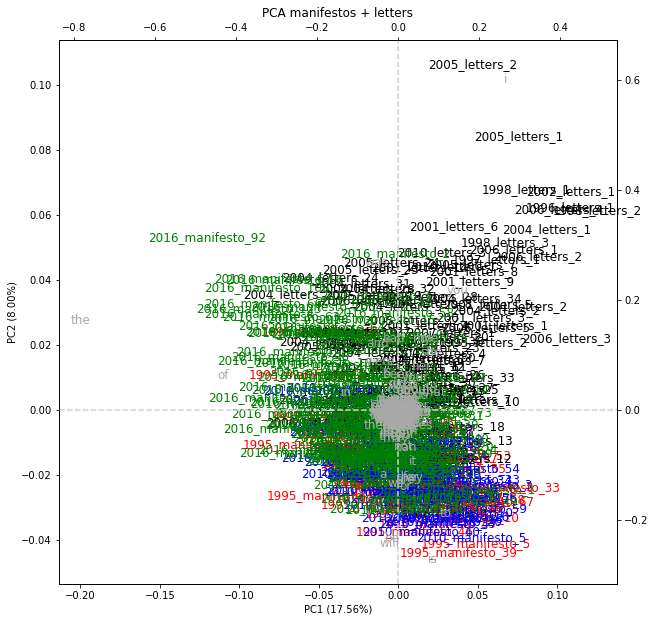

In [ ]:
# fit pca

pca = decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(normalized_documents)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, titles, title='PCA manifestos + letters')

## 3. Principal Component Analysis manifestos

### 3.1. Preprocessing the data

In [ ]:
# load directory and segment txt-files

df = load_directory('C:/Users/Lenovo/Desktop/CLS/final_project_corrected/data/manifestos/*.txt', max_length=1500)
df.sample(5)

,titles,years,documents
16,1995_manifesto_17,1995,opposes technology. it is not necessary for th...
27,2010_manifesto_6,2010,in which relatively few people — maybe 500 or ...
49,2016_manifesto_8,2016,far-fetched as it may appear to the denizens o...
52,2016_manifesto_11,2016,"things that exist on earth, together with the ..."
32,2010_manifesto_11,2010,regulation will inevitably follow the introduc...


In [ ]:
# titles, years, and documents to lists

titles = df['titles'].tolist()
years = df['years'].tolist()
documents = df['documents'].tolist()

In [ ]:
# preprocess documents

preprocessed_documents = [preprocess_text(document, 'english') for document in documents]

In [ ]:
# extract most frequent words

mfw = extract_mfw(preprocessed_documents, n=300)

In [ ]:
# save most frequent words

save_mfw(mfw)

In [ ]:
# load most frequent words after manually culling

mfw = load_mfw(filepath='mfw/mfw_culled_manifestos.txt')

In [ ]:
# join tokens

preprocessed_documents = [' '.join(map(str, l)) for l in preprocessed_documents]

In [ ]:
# bag of words

vectorizer = text.CountVectorizer(vocabulary=mfw, token_pattern=r'(?u)\b\w+\b')
vectorized_documents = vectorizer.fit_transform(preprocessed_documents).toarray()

vectorized_documents.shape

(86, 140)

In [ ]:
# normalize documents

normalized_documents = preprocessing.normalize(vectorized_documents.astype(float), norm='l1')

### 3.1. Principal Component Analysis

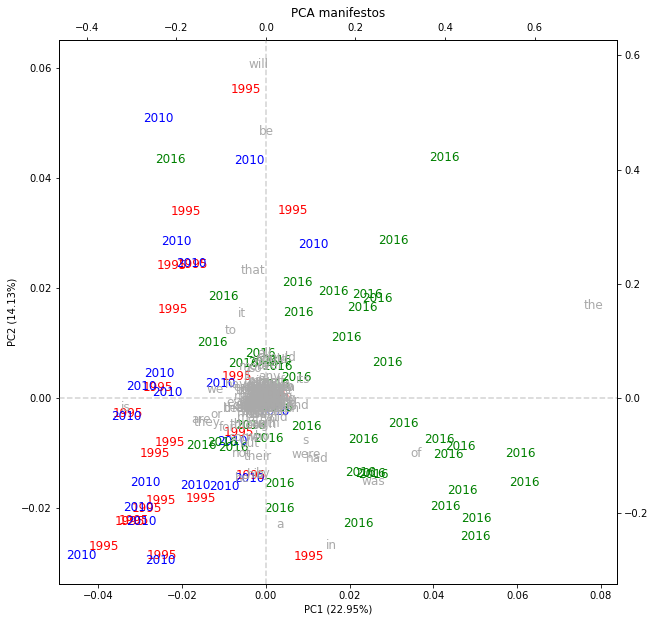

In [ ]:
# fit pca

pca = decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(normalized_documents)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, years, title='PCA manifestos')